# Практика №3

Теперь в качестве акустической модели мы будем использовать простой DNN классификатор. На каждом кадре записи мы будем подавать его вектор признаков на DNN, которая будет выдавать "распределение вероятностей" по фонемам. Далее это распределение мы будем использовать в нашем алгоритме распознавания по словарю. Схема работы такого классификатора представлена ниже: 

![](https://drive.google.com/uc?export=view&id=1dv0VuE8DIoKXETbvnZq2PMixkWMCJOxr)

### Bootstrap

In [3]:
!gdown --id '1meikF0XqBUnVZKoY3160MQ0R25lq-EMu'
!gdown --id '1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox'

!unzip -q lab2.zip
!unzip -q train_librispeech_10h.zip
!mv lab2 lab3
!mv train_librispeech_10h lab3/data
!rm -rf lab2.zip sample_data train_librispeech_10h.zip
%cd lab3

Downloading...
From: https://drive.google.com/uc?id=1meikF0XqBUnVZKoY3160MQ0R25lq-EMu
To: /content/lab2.zip
100% 1.66M/1.66M [00:00<00:00, 87.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox
To: /content/train_librispeech_10h.zip
679MB [00:04, 144MB/s]
/content/lab3


In [4]:
import os
import numpy as np
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
import torch
import torch.nn as nn
import torch.functional as F


%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [5]:
# загрузка списка допустимых фонем:
def load_phones_dict(phones_file):
    phones_dict = {}
    with open(phones_file, encoding='utf-8') as fn:
        for index, line in enumerate(fn):
            phones_dict[line.strip()] = index
    return phones_dict

# загрузка покадровой фонемной разметки в словарь:
def load_phone_aligment(aligment_file):
    ali_dict = {}
    with open(aligment_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            ali_dict[line[0]] = line[1:]
    return ali_dict

# подсчет акустиеских признаков для записей из папки:
def load_data_dict(dir_path, count=None):
    data_dict = {}
    step = 0
    for wav_name in tqdm(os.listdir(dir_path)):
        x, sr = librosa.load(os.path.join(dir_path, wav_name), sr=None) 
        mfcc = librosa.feature.mfcc(x, sr=sr, n_mfcc=13, 
                                    n_fft=int(sr * 0.025),
                                    hop_length=int(sr * 0.01))
        step += 1
        if count and step == count:
            print(f'Early stop at {step}th file..')
            break
        data_dict[wav_name.split('.')[0]] = mfcc.T  
    return data_dict


phones_file = 'data/train_librispeech_10h/phones'
phones_dict = load_phones_dict(phones_file)

ali_file = 'data/train_librispeech_10h/ali_phones.txt'
ali_dict = load_phone_aligment(ali_file)

train_records_dir = 'data/train_librispeech_10h/wav_dir'
feats_dict = load_data_dict(train_records_dir, count=1000)

Early stop at 1000th file..


### Априорная вероятность:

![](https://drive.google.com/uc?export=view&id=1WhjclhXm2POYsCgvxp3iAIOvT9F_k8If)

In [6]:
# объединение кадров признаков с соответствующими им фонемам:
def combain_data(ali_dict, feats_dict, phones_dict, side_context=0):
    data_list = []
    priors_list = [0] * len(phones_dict)
    for file_name in feats_dict.keys():
        file_feats = feats_dict[file_name]
        #Adding padding
        file_feats = np.pad(file_feats, ((side_context, side_context), (0, 0)), mode='edge')
        file_ali = ali_dict[file_name]
        #Changed counting
        for frame in range(min(len(file_feats - 2 * side_context), len(file_ali))):
            #Adding corresponding slice instead of single frame
            data_list.append(np.append(file_feats[frame:frame + 2 * side_context + 1],
                                       phones_dict[file_ali[frame]]))
            priors_list[phones_dict[file_ali[frame]]] += 1
    return data_list, np.array(priors_list)/sum(priors_list)

side_context = 0
data_list, priors_list = combain_data(ali_dict, feats_dict, phones_dict, side_context)
data_list = np.random.permutation(data_list)

In [7]:
class CommonDataSet():

    def __init__(self, data_list, device, valid_proportion=0.1):
        self.train = data_list[:int((1-valid_proportion)*len(data_list))]
        self.valid = data_list[int((1-valid_proportion)*len(data_list)):]
        self.device = device
        
    def num_batches(self, batch_size):
        return len(self.train)//batch_size        
        
    def next_batch(self, batch_size):
        for i in range(self.num_batches(batch_size)):
            batch_xs = torch.tensor(self.train[i * batch_size:(i + 1) * batch_size, :-1], dtype=torch.float32)
            batch_ys = torch.tensor(self.train[i * batch_size:(i + 1) * batch_size,-1].ravel(), dtype=torch.int64)

            yield batch_xs.to(device), batch_ys.to(device)

In [8]:
class MyNet(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super(MyNet, self).__init__()
        # params:
        input_dim = input_dim       # размерность входных признаков
        n_nodes_hl1 = 256
        n_nodes_hl2 = 256
        n_nodes_hl3 = 256
        n_nodes_hl4 = 256
        output_dim = output_dim     # количество выходных классов (фонем)
        # FC layers:
        self.fc1 = nn.Linear(input_dim, n_nodes_hl1)
        self.fc2 = nn.Linear(n_nodes_hl1, n_nodes_hl2)
        self.fc3 = nn.Linear(n_nodes_hl2, n_nodes_hl3)
        self.fc4 = nn.Linear(n_nodes_hl3, n_nodes_hl4)
        self.fc5 = nn.Linear(n_nodes_hl4, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return (x)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data:
data_set = CommonDataSet(data_list, device)

batch_size = 256

# training network model:
start = time.time() 
net = MyNet(input_dim=(data_list[0].shape[0] - 1),
            output_dim=len(phones_dict.keys())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

loss_list = []

print('TRAINIG IS STARTED...')
for epoch in range(10):
    running_loss = 0
    counter = 0
    for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                   total=data_set.num_batches(batch_size), \
                                   desc='epoch {}'.format(epoch)):
        optimizer.zero_grad()
        output = net(batch_xs)

        loss = criterion(output, batch_ys)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        counter += 1
        
    print('loss is: {:.4f}'.format((running_loss / counter)))
    loss_list.append(running_loss / counter)
    
end = time.time()
minutes = (end - start) // 60
seconds = np.mod((end - start), 60)
print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))

TRAINIG IS STARTED...



loss is: 2.2862



loss is: 2.1562



loss is: 2.1190



loss is: 2.0953



loss is: 2.0771



loss is: 2.0621



loss is: 2.0489



loss is: 2.0372



loss is: 2.0262



loss is: 2.0160
Time is: 2 min 29 sec


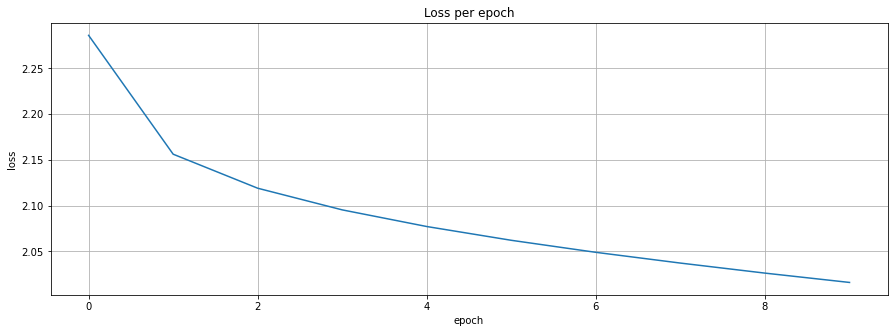

In [8]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.plot(loss_list)
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

In [9]:
net.cpu()
with torch.no_grad():
    correct_cnt = 0
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        output = net.forward(ftr)
        correct_cnt += (output.argmax().item() == true_label)
        
    print("Total frame accuracy is {:.3f}".format(correct_cnt / data_set.valid.shape[0]))


Total frame accuracy is 0.431


In [10]:
class_correct = [0 for x in range(len(phones_dict.keys()))]
class_total = [0 for x in range(len(phones_dict.keys()))]
net.cpu()
with torch.no_grad():
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        output = net.forward(ftr)
        predict_label = output.argmax().item()
        
        class_correct[predict_label] += (predict_label == int(true_label))
        class_total[int(true_label)] += 1

for idx, phone in enumerate(phones_dict.keys()):
    if class_total[idx]:
        print('{:3s}: {:.2f} : {}/{}'.format(phone, class_correct[idx] / class_total[idx], \
                                                     class_correct[idx], class_total[idx]))


SIL: 0.95 : 21635/22710
SPN: 0.00 : 0/516
AA0: 0.00 : 0/31
AA1: 0.28 : 495/1790
AA2: 0.00 : 0/85
AE0: 0.00 : 0/51
AE1: 0.43 : 1536/3600
AE2: 0.00 : 0/81
AH0: 0.26 : 1438/5589
AH1: 0.25 : 471/1861
AH2: 0.00 : 0/40
AO0: 0.00 : 0/36
AO1: 0.46 : 892/1938
AO2: 0.00 : 0/44
AW0: 0.00 : 0/16
AW1: 0.05 : 50/1050
AW2: 0.00 : 0/40
AY0: 0.00 : 0/31
AY1: 0.26 : 765/2925
AY2: 0.00 : 0/199
B  : 0.12 : 188/1582
CH : 0.03 : 22/836
D  : 0.11 : 451/3972
DH : 0.02 : 43/1936
EH0: 0.04 : 2/50
EH1: 0.31 : 862/2758
EH2: 0.00 : 0/109
ER0: 0.34 : 880/2585
ER1: 0.10 : 91/933
ER2: 0.00 : 0/12
EY0: 0.00 : 0/21
EY1: 0.42 : 975/2331
EY2: 0.01 : 1/132
F  : 0.47 : 1062/2249
G  : 0.01 : 4/782
HH : 0.22 : 496/2229
IH0: 0.07 : 190/2675
IH1: 0.15 : 313/2145
IH2: 0.00 : 0/105
IY0: 0.26 : 546/2138
IY1: 0.62 : 1403/2272
IY2: 0.00 : 0/50
JH : 0.03 : 18/625
K  : 0.29 : 886/3021
L  : 0.57 : 2338/4067
M  : 0.37 : 1152/3121
N  : 0.50 : 2990/5936
NG : 0.15 : 204/1351
OW0: 0.00 : 0/209
OW1: 0.21 : 403/1881
OW2: 0.00 : 0/107
OY1: 0

### Распознавание по словарю с помощью нейронки

In [9]:
# теперь будем распознавать по словарю, состоящему из конечных слов
# для этого нужно загрузить файл лексикона, который определяет из каких фонем состоят наши слова
def load_lexicon_dict(lexicon_file):
    lexicon_dict = {}
    with open(lexicon_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            lexicon_dict[line[0]] = line[1:]
    return lexicon_dict

In [10]:
class AcousticModel:
    def __init__(self, phone_name, phone_index, priors_list):
        self.phone_name = phone_name
        self.phone_index = phone_index
        self.phone_prior = priors_list[phone_index]
        
    def distance(self, input_feats, nnet):
        with torch.no_grad():
            predicts = nnet.forward(torch.tensor(input_feats, dtype=torch.float32))
            softmax = torch.nn.functional.softmax(predicts, dim=0)
        return -np.log(softmax[self.phone_index].item() / self.phone_prior)

class State:
    def __init__(self, model, index):  
        self.model = model                     # вектор признаков узла
        self.is_final = False                  # является ли этот узел финальнвм в слове
        self.word = None                       # слово эталона (назначается только для финального узла)
        self.best_token = None                 # лучший токен (по минимуму дистанции) в узле
        self.current_word = None               # текущее слово эталона
        self.next_states = []                  # список следующих узлов
        self.index = index                     # индекс узла 

        
def load_graph(lexicon_dict, phones_dict, priors_list):
    start_state = State(None, 0)
    graph = [start_state, ]
    state_index = 1
    for word in lexicon_dict.keys():
        previous_state = start_state
        for phone in lexicon_dict[word]:
            state = State(AcousticModel(phone, phones_dict[phone], priors_list), state_index)
            state.current_word = word           # слово эталона теперь будет храниться в каждом узле
            state.next_states.append(state)     # add loop
            previous_state.next_states.append(state)
            previous_state = state 
            graph.append(state)
            state_index += 1
        if state:
            state.word = word
            state.is_final = True
    return graph

In [17]:
class Token:
    def __init__(self, state, dist=0.0, word=""):
        self.state = state       # стейт графа, в котором токен находится в текущий момент
        self.dist = dist         # общая накопленная дистанция пути, пройденного токеном
        self.word = word         # слово, которое распозналось токеном
        self.alive = True


def beam_pruning(next_tokens, threshold):   
    alive_tokens = [token for token in next_tokens if token.alive]
    best_token = alive_tokens[np.argmin([token.dist for token in alive_tokens if token.alive])]
    for token in next_tokens:
        if token.dist > best_token.dist + threshold:
            token.alive = False
    return next_tokens


def state_pruning(next_tokens):
    for i in range(len(next_tokens)): 
        state_index = next_tokens[i].state.index
        if not graph[state_index].best_token:
            graph[state_index].best_token = next_tokens[i]
        else:
            if next_tokens[i].dist <= graph[state_index].best_token.dist:
                graph[state_index].best_token.alive = False
                graph[state_index].best_token = next_tokens[i]
            else:
                next_tokens[i].alive = False
    for token in next_tokens:                           
        index = token.state.index                        
        if graph[index].best_token:                     
            graph[index].best_token = None              
    return next_tokens


def recognize(filename, features, graph, nnet, recognition_results, beam_threshold, side_context=0):

    start_state = graph[0]
    active_tokens = [Token(start_state), ]
    next_tokens = []
    
    # print(features.shape)
    #Adding padding for feature
    features = np.pad(features, ((side_context, side_context), (0, 0)), mode='edge')
    for frame in range(len(features) - 2 * side_context):
        #Using several frames to form features
        ftr_frame = np.ravel(features[frame:frame + 2 * side_context + 1])
        for token in active_tokens:
            if token.alive:
                for transition_state in token.state.next_states:
                    new_token = Token(transition_state, token.dist, token.word)
                    new_token.dist += transition_state.model.distance(ftr_frame, nnet)
                    next_tokens.append(new_token)
        # state and beam prunings:
        next_tokens = state_pruning(next_tokens)         
        next_tokens = beam_pruning(next_tokens, beam_threshold) 

        active_tokens = next_tokens
        next_tokens = []                                    
        
    # поиск финальных токенов:
    final_tokens = []
    for token in active_tokens:
        if token.state.is_final and token.alive:
            final_tokens.append(token)

    # если нет финальных, то берем лучший из выживших:
    if len(final_tokens) != 0:
        win_token = final_tokens[np.argmin([token.dist for token in final_tokens])]
    else:
        alive_tokens = [token for token in active_tokens if token.alive]
        win_token = alive_tokens[np.argmin([token.dist for token in alive_tokens])]
        win_token.state.word = win_token.state.current_word

    # вывод результата
    print(f"result: {filename:<27} ==> {win_token.state.word}")

    # совпадает ли запись с полученным эталоном:  
    record_word = filename.split('_')[0]
    etalon_word = win_token.state.word.split('_')[0]
    recognition_results.append(etalon_word.lower() == record_word)

    return recognition_results

In [18]:
def run_recognizer(records_data_dict, graph, nnet, beam_threshold=10, side_context=0):
    start_time = time.time()
    recognition_results = []

    for filename in records_data_dict.keys():    
        recognition_results = recognize(filename,
                                        records_data_dict[filename],
                                        graph, nnet,
                                        recognition_results, beam_threshold, side_context=side_context)

    print("-" * 60)
    print(f"WER is: {(1 - sum(recognition_results)/len(recognition_results))*100:.2f}%")
    print(f"Total time is: {time.time() - start_time:.2f} sec")
    print("-" * 60)

### Запустим распознавание на базе YES_NO

In [15]:
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/yes_no/records")

run_recognizer(records_data_dict, graph, net.cpu(), beam_threshold=100, side_context=0)


result: yes_ff63ab0b_nohash_0       ==> YES
result: no_ad89eb1e_nohash_0        ==> NO
result: no_49af4432_nohash_0        ==> NO
result: no_4abb2400_nohash_0        ==> YES
result: yes_fc94edb0_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: yes_fe1916ba_nohash_0       ==> YES
result: yes_39a6b995_nohash_0       ==> YES
result: yes_39a12648_nohash_0       ==> YES
result: no_4394fc7c_nohash_0        ==> NO
------------------------------------------------------------
WER is: 10.00%
Total time is: 3.05 sec
------------------------------------------------------------


### Запустим распознавание на базе Digits

In [16]:
lexicon_file = 'data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/digits/records")

run_recognizer(records_data_dict, graph, net.cpu(), beam_threshold=50, side_context=0)


result: five_f852895b_nohash_0      ==> FIVE
result: two_fce65496_nohash_0       ==> TWO
result: four_fce65496_nohash_0      ==> FOUR
result: one_ffa76c4a_nohash_0       ==> FOUR
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
result: zero_f852895b_nohash_0      ==> FIVE
result: seven_fd32732a_nohash_0     ==> SEVEN
result: six_ffd2ba2f_nohash_0       ==> SIX
result: eight_daf230ac_nohash_0     ==> EIGHT
result: six_ffbb695d_nohash_0       ==> TWO
result: two_fb2f3242_nohash_0       ==> TWO
result: three_fce96bac_nohash_0     ==> TWO
result: nine_ccea893d_nohash_0      ==> NINE
result: nine_fbe51750_nohash_0      ==> NINE
result: zero_f92e49f3_nohash_3      ==> ZERO
result: one_fc2411fe_nohash_0       ==> NINE
result: four_ffbb695d_nohash_0      ==> FOUR
result: eight_da584bc0_nohash_4     ==> SIX
result: three_feb1d305_nohash_0     ==> THREE
------------------------------------------------------------
WER is: 30.00%
Total time is: 24.25 sec


### <b>Задание №1</b> (5 баллов):
Реализовать контексты для входных признаков путем конкатенации кадров слева и справа от текущего. Не забудьте поддержать это и в функции распознавания. Насколько улучшилось качество на дата сетах?

![](https://drive.google.com/uc?export=view&id=1ft0z6CPhX20cJnA373uLoYwHPEagaKyo)

### Начальные условия при запуске из коробки:
1. Training Loss = 2.0166
2. Accuracy = 0.429
3. YES/NO WER = 10%
4. Digits WER = 30%


In [17]:
#Reload Data
side_context = 2
data_list, priors_list = combain_data(ali_dict, feats_dict, phones_dict, side_context)
data_list = np.random.permutation(data_list)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data:
data_set = CommonDataSet(data_list, device)

batch_size = 256

# training network model:
start = time.time() 
net = MyNet(input_dim=(data_list[0].shape[0] - 1),
            output_dim=len(phones_dict.keys())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

loss_list = []

print('TRAINIG IS STARTED...')
for epoch in range(10):
    running_loss = 0
    counter = 0
    for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                   total=data_set.num_batches(batch_size), \
                                   desc='epoch {}'.format(epoch)):
        optimizer.zero_grad()
        output = net(batch_xs)

        loss = criterion(output, batch_ys)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        counter += 1
        
    print('loss is: {:.4f}'.format((running_loss / counter)))
    loss_list.append(running_loss / counter)
    
end = time.time()
minutes = (end - start) // 60
seconds = np.mod((end - start), 60)
print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))

TRAINIG IS STARTED...



loss is: 1.9644



loss is: 1.7305



loss is: 1.6518



loss is: 1.6022



loss is: 1.5653



loss is: 1.5355



loss is: 1.5107



loss is: 1.4896



loss is: 1.4709



loss is: 1.4540
Time is: 2 min 26 sec


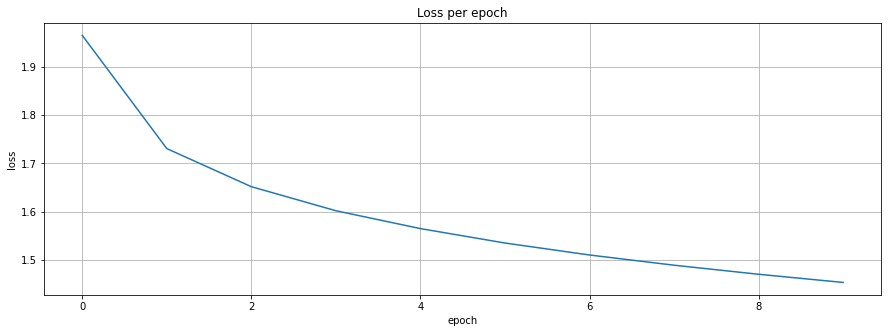

In [19]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.plot(loss_list)
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

In [20]:
net.cpu()
with torch.no_grad():
    correct_cnt = 0
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        output = net.forward(ftr)
        correct_cnt += (output.argmax().item() == true_label)
        
    print("Total frame accuracy is {:.3f}".format(correct_cnt / data_set.valid.shape[0]))


Total frame accuracy is 0.555


In [21]:
# YES/NO Recognition
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/yes_no/records")

run_recognizer(records_data_dict, graph, net.cpu(), beam_threshold=100, side_context=2)


result: yes_ff63ab0b_nohash_0       ==> YES
result: no_ad89eb1e_nohash_0        ==> NO
result: no_49af4432_nohash_0        ==> NO
result: no_4abb2400_nohash_0        ==> NO
result: yes_fc94edb0_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: yes_fe1916ba_nohash_0       ==> YES
result: yes_39a6b995_nohash_0       ==> YES
result: yes_39a12648_nohash_0       ==> YES
result: no_4394fc7c_nohash_0        ==> NO
------------------------------------------------------------
WER is: 0.00%
Total time is: 2.70 sec
------------------------------------------------------------


In [22]:
#Digits recognition
lexicon_file = 'data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/digits/records")

run_recognizer(records_data_dict, graph, net.cpu(), beam_threshold=50, side_context=2)


result: five_f852895b_nohash_0      ==> FIVE
result: two_fce65496_nohash_0       ==> TWO
result: four_fce65496_nohash_0      ==> FOUR
result: one_ffa76c4a_nohash_0       ==> ONE
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
result: zero_f852895b_nohash_0      ==> ZERO
result: seven_fd32732a_nohash_0     ==> SEVEN
result: six_ffd2ba2f_nohash_0       ==> SIX
result: eight_daf230ac_nohash_0     ==> EIGHT
result: six_ffbb695d_nohash_0       ==> SIX
result: two_fb2f3242_nohash_0       ==> TWO
result: three_fce96bac_nohash_0     ==> THREE
result: nine_ccea893d_nohash_0      ==> NINE
result: nine_fbe51750_nohash_0      ==> NINE
result: zero_f92e49f3_nohash_3      ==> ZERO
result: one_fc2411fe_nohash_0       ==> ONE
result: four_ffbb695d_nohash_0      ==> FOUR
result: eight_da584bc0_nohash_4     ==> EIGHT
result: three_feb1d305_nohash_0     ==> THREE
------------------------------------------------------------
WER is: 0.00%
Total time is: 22.05 sec

## Увеличение контекста до 4-х кадров позволило достичь WER = 0% на обоих тестах. Я бы, правда, не особо радовался - тестовая выборка слишком маленькая.
Loss снизился до 1.44, accuracy возросла до 0.55

### <b>Задание №2</b> (5 баллов):
Повысить качество классификации фонем за счет улучшения архитектуры нейронной сети, оптимизатора, других речевых признаков и т.п. Составить небольшой отчет на основе результатов перебора использованных способов. 

### Так как лучше 0 WER не бывает - убираем контекст и начинаем играть с моделью

Что было сделано:
1) Контекст сокращен до одного кадра и изменена архитектура сети - Stack More Layers не работает, не хватает данных для более точного определения фонем
2) Начал играть с шириной окна и архитектурой сети - удалось достичь точности распознавания фонем 70%. Эта архитектура и приведена ниже. Ширина окна - 9, 7 слоев со скипами.

In [12]:
class MyBigNet(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super(MyBigNet, self).__init__()
        # params:
        input_dim = input_dim       # размерность входных признаков
        n_nodes_hl1 = 1024
        n_nodes_hl2 = 1024
        n_nodes_hl3 = 1024
        n_nodes_hl4 = 1024
        n_nodes_hl5 = 1024
        n_nodes_hl6 = 1024
        output_dim = output_dim     # количество выходных классов (фонем)
        # FC layers:
        self.fc1 = nn.Linear(input_dim, n_nodes_hl1)
        self.fc2 = nn.Linear(n_nodes_hl1, n_nodes_hl2)
        self.fc3 = nn.Linear(n_nodes_hl2, n_nodes_hl3)
        self.fc4 = nn.Linear(n_nodes_hl3, n_nodes_hl4)
        self.fc5 = nn.Linear(n_nodes_hl4, n_nodes_hl5)
        self.fc6 = nn.Linear(n_nodes_hl5, n_nodes_hl6)
        self.fc7 = nn.Linear(n_nodes_hl4, output_dim)

    def forward(self, x):
        x1 = torch.relu(self.fc1(x))
        x2 = torch.relu(self.fc2(x1))
        x1 = torch.relu(self.fc3(x2)) + x1
        x2 = torch.relu(self.fc4(x1))
        x1 = torch.relu(self.fc5(x2)) + x1
        x2 = torch.relu(self.fc6(x1))
        x1 = self.fc7(x2)
        return (x1)

In [13]:
#Reload Data
side_context = 4
data_list, priors_list = combain_data(ali_dict, feats_dict, phones_dict, side_context)
data_list = np.random.permutation(data_list)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data:
data_set = CommonDataSet(data_list, device)

batch_size = 256

# training network model:
start = time.time() 
net = MyBigNet(input_dim=(data_list[0].shape[0] - 1),
               output_dim=len(phones_dict.keys())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

loss_list = []

print('TRAINIG IS STARTED...')
for epoch in range(10):
    running_loss = 0
    counter = 0
    for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                   total=data_set.num_batches(batch_size), \
                                   desc='epoch {}'.format(epoch)):
        optimizer.zero_grad()
        output = net(batch_xs)

        loss = criterion(output, batch_ys)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        counter += 1
        
    print('loss is: {:.4f}'.format((running_loss / counter)))
    loss_list.append(running_loss / counter)
    
end = time.time()
minutes = (end - start) // 60
seconds = np.mod((end - start), 60)
print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))

TRAINIG IS STARTED...



loss is: 1.9029



loss is: 1.4512



loss is: 1.2878



loss is: 1.1699



loss is: 1.0653



loss is: 0.9664



loss is: 0.8710



loss is: 0.7789



loss is: 0.6915



loss is: 0.6100
Time is: 2 min 24 sec


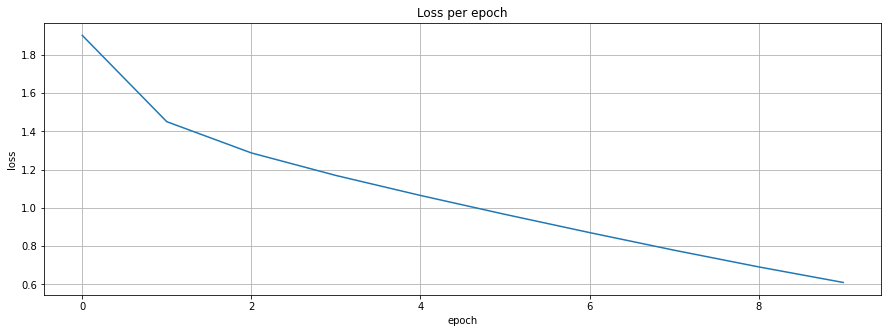

In [14]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.plot(loss_list)
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

In [15]:
net.cpu()
with torch.no_grad():
    correct_cnt = 0
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], 
                                    data_set.valid[:, -1]), 
                                total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        output = net.forward(ftr)
        correct_cnt += (output.argmax().item() == true_label)
        
    print("Total frame accuracy is {:.3f}".format(correct_cnt / data_set.valid.shape[0]))


Total frame accuracy is 0.686


In [19]:
# YES/NO Recognition
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/yes_no/records")

run_recognizer(records_data_dict, graph, net.cpu(), 
               beam_threshold=100, side_context=side_context)


result: yes_ff63ab0b_nohash_0       ==> YES
result: no_ad89eb1e_nohash_0        ==> NO
result: no_49af4432_nohash_0        ==> NO
result: no_4abb2400_nohash_0        ==> NO
result: yes_fc94edb0_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: yes_fe1916ba_nohash_0       ==> YES
result: yes_39a6b995_nohash_0       ==> YES
result: yes_39a12648_nohash_0       ==> YES
result: no_4394fc7c_nohash_0        ==> NO
------------------------------------------------------------
WER is: 0.00%
Total time is: 11.70 sec
------------------------------------------------------------


In [25]:
#Digits recognition
lexicon_file = 'data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/digits/records")

run_recognizer(records_data_dict, graph, net.cpu(), 
               beam_threshold=100, side_context=side_context)


result: five_f852895b_nohash_0      ==> FIVE
result: two_fce65496_nohash_0       ==> TWO
result: four_fce65496_nohash_0      ==> FOUR
result: one_ffa76c4a_nohash_0       ==> ONE
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
result: zero_f852895b_nohash_0      ==> SEVEN
result: seven_fd32732a_nohash_0     ==> SEVEN
result: six_ffd2ba2f_nohash_0       ==> SIX
result: eight_daf230ac_nohash_0     ==> EIGHT
result: six_ffbb695d_nohash_0       ==> SIX
result: two_fb2f3242_nohash_0       ==> TWO
result: three_fce96bac_nohash_0     ==> THREE
result: nine_ccea893d_nohash_0      ==> NINE
result: nine_fbe51750_nohash_0      ==> NINE
result: zero_f92e49f3_nohash_3      ==> ZERO
result: one_fc2411fe_nohash_0       ==> NINE
result: four_ffbb695d_nohash_0      ==> FOUR
result: eight_da584bc0_nohash_4     ==> EIGHT
result: three_feb1d305_nohash_0     ==> THREE
------------------------------------------------------------
WER is: 10.00%
Total time is: 121.40

## Качество работы модели стало хуже, а время работы выросло... Возможно стоит смотреть в сторону упрощения... Или учиться лучше подбирать архитектуры.